In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from src.data import (
    compute_psi, 
    compute_psi_for_features,
    inject_gradual_drift,
    inject_sudden_shift,
    inject_noise
)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load and prepare data
df = pd.read_csv('../data/hour.csv')
df['dteday'] = pd.to_datetime(df['dteday'])

# Split by year
train_2011 = df[df['yr'] == 0].copy()
eval_2012 = df[df['yr'] == 1].copy()

feature_cols = [
    'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed'
]

# Train baseline model
X_train = train_2011[feature_cols]
y_train = train_2011['cnt']

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Baseline metrics on unmodified 2012 data
X_test_original = eval_2012[feature_cols].copy()
y_test = eval_2012['cnt']
y_pred_baseline = rf_model.predict(X_test_original)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

print(f"Baseline RMSE on 2012 (no synthetic drift): {baseline_rmse:.2f}")

Baseline RMSE on 2012 (no synthetic drift): 125.66


In [3]:
# Helper function to evaluate drift experiment
def evaluate_experiment(name, X_train_ref, X_test_drifted, y_test, model, features_to_check=None):
    """
    Evaluate PSI and RMSE for a drift experiment.
    """
    if features_to_check is None:
        features_to_check = ['temp', 'atemp', 'hum', 'windspeed']
    
    # Compute PSI
    psi_results = compute_psi_for_features(X_train_ref, X_test_drifted, features_to_check)
    
    # Compute predictions and RMSE
    y_pred = model.predict(X_test_drifted)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return {
        'name': name,
        'psi': psi_results,
        'rmse': rmse,
        'predictions': y_pred
    }

## Experiment A: Gradual Humidity Drift

**Scenario**: Weather sensors slowly degrade, causing systematic humidity measurement bias.

**Expected**: PSI detects drift, RMSE increases proportionally.

In [7]:
# Experiment A: Gradual humidity bias
# Add constant bias to humidity at different levels
bias_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
exp_a_results = []

for bias in bias_levels:
    # Create drifted test data by adding constant bias
    X_test_drifted = X_test_original.copy()
    X_test_drifted['hum'] = (X_test_drifted['hum'] + bias).clip(0, 1)
    
    # Evaluate
    result = evaluate_experiment(
        f"Hum +{bias:.2f}",
        X_train,
        X_test_drifted,
        y_test,
        rf_model,
        features_to_check=['hum']
    )
    result['drift_level'] = bias
    result['psi_hum'] = result['psi']['hum']
    exp_a_results.append(result)
    
exp_a_df = pd.DataFrame(exp_a_results)
print("Experiment A: Gradual Humidity Drift")
print("="*50)
for _, row in exp_a_df.iterrows():
    psi_status = "✓ No drift" if row['psi_hum'] < 0.1 else "⚠ Moderate" if row['psi_hum'] < 0.2 else "⚡ Significant"
    print(f"Drift +{row['drift_level']:.2f}: PSI={row['psi_hum']:.4f} ({psi_status}), RMSE={row['rmse']:.2f}")

Experiment A: Gradual Humidity Drift
Drift +0.00: PSI=0.0483 (✓ No drift), RMSE=125.66
Drift +0.05: PSI=0.0232 (✓ No drift), RMSE=127.78
Drift +0.10: PSI=0.1681 (⚠ Moderate), RMSE=130.80
Drift +0.15: PSI=0.4573 (⚡ Significant), RMSE=134.85
Drift +0.20: PSI=0.9289 (⚡ Significant), RMSE=139.91
Drift +0.25: PSI=3.0409 (⚡ Significant), RMSE=145.51
Drift +0.30: PSI=3.6661 (⚡ Significant), RMSE=151.16


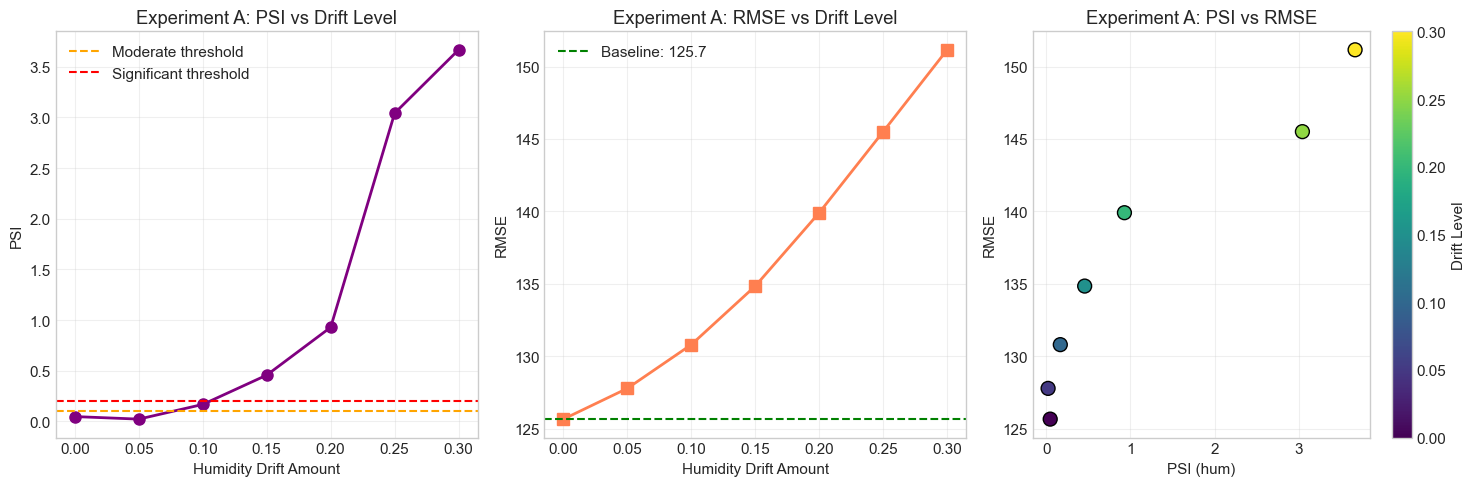


✓ EXPERIMENT A CONCLUSION: PSI successfully detects gradual feature drift
  As humidity bias increases, both PSI and RMSE increase proportionally.


In [8]:
# Visualize Experiment A
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# PSI vs Drift Level
axes[0].plot(exp_a_df['drift_level'], exp_a_df['psi_hum'], 'o-', color='purple', linewidth=2, markersize=8)
axes[0].axhline(y=0.1, color='orange', linestyle='--', label='Moderate threshold')
axes[0].axhline(y=0.2, color='red', linestyle='--', label='Significant threshold')
axes[0].set_xlabel('Humidity Drift Amount')
axes[0].set_ylabel('PSI')
axes[0].set_title('Experiment A: PSI vs Drift Level')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE vs Drift Level
axes[1].plot(exp_a_df['drift_level'], exp_a_df['rmse'], 's-', color='coral', linewidth=2, markersize=8)
axes[1].axhline(y=baseline_rmse, color='green', linestyle='--', label=f'Baseline: {baseline_rmse:.1f}')
axes[1].set_xlabel('Humidity Drift Amount')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Experiment A: RMSE vs Drift Level')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# PSI vs RMSE
axes[2].scatter(exp_a_df['psi_hum'], exp_a_df['rmse'], c=exp_a_df['drift_level'], cmap='viridis', s=100, edgecolor='black')
axes[2].set_xlabel('PSI (hum)')
axes[2].set_ylabel('RMSE')
axes[2].set_title('Experiment A: PSI vs RMSE')
cbar = plt.colorbar(axes[2].collections[0], ax=axes[2])
cbar.set_label('Drift Level')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ EXPERIMENT A CONCLUSION: PSI successfully detects gradual feature drift")
print("  As humidity bias increases, both PSI and RMSE increase proportionally.")

## Experiment B: Sudden Morning Rush Zeroing

**Scenario**: A data collection error sets all morning rush (7-9am) rentals to zero, but feature distributions remain unchanged.

**Expected**: PSI shows no feature drift, but RMSE spikes due to target manipulation.

In [9]:
# Experiment B: Sudden morning rush zeroing
# This simulates a scenario where model error increases WITHOUT feature drift
# We'll modify predictions as if certain time periods behave differently

# Create scenario: What if morning rush hour (7-9am) had much lower actual values?
# This simulates concept drift without data drift

morning_mask = eval_2012['hr'].isin([7, 8, 9])
afternoon_mask = eval_2012['hr'].isin([16, 17, 18])

# Option 1: Zero morning rush (extreme)
y_test_modified = y_test.copy()
y_test_morning_zero = y_test.copy()
y_test_morning_zero.loc[morning_mask] = 0

# Option 2: Reduce morning rush by 50%
y_test_morning_reduced = y_test.copy()
y_test_morning_reduced.loc[morning_mask] = y_test.loc[morning_mask] * 0.5

# Features remain unchanged!
X_test_B = X_test_original.copy()

# Compute PSI (should be ~0 since features unchanged)
psi_B = compute_psi_for_features(X_train, X_test_B, ['temp', 'atemp', 'hum', 'windspeed'])

# Compute RMSE with modified targets
y_pred_B = rf_model.predict(X_test_B)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_B))
rmse_morning_zero = np.sqrt(mean_squared_error(y_test_morning_zero, y_pred_B))
rmse_morning_reduced = np.sqrt(mean_squared_error(y_test_morning_reduced, y_pred_B))

print("Experiment B: Sudden Concept Drift (Morning Rush Manipulation)")
print("="*60)
print("\nPSI Values (features unchanged):")
for feature, psi in psi_B.items():
    print(f"  {feature}: {psi:.4f}")

print(f"\nRMSE Comparison:")
print(f"  Baseline:                {rmse_baseline:.2f}")
print(f"  Morning rush -50%:       {rmse_morning_reduced:.2f} (Δ = +{rmse_morning_reduced - rmse_baseline:.2f})")
print(f"  Morning rush zeroed:     {rmse_morning_zero:.2f} (Δ = +{rmse_morning_zero - rmse_baseline:.2f})")

Experiment B: Sudden Concept Drift (Morning Rush Manipulation)

PSI Values (features unchanged):
  temp: 0.0355
  atemp: 0.0329
  hum: 0.0483
  windspeed: 0.0036

RMSE Comparison:
  Baseline:                125.66
  Morning rush -50%:       111.91 (Δ = +-13.75)
  Morning rush zeroed:     137.25 (Δ = +11.59)


/var/folders/qc/qc6_mpxx4n38647wjfbjb3000000gn/T/ipykernel_78486/1631883679.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.5  7.  20.  ... 42.5 98.  78.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_test_morning_reduced.loc[morning_mask] = y_test.loc[morning_mask] * 0.5


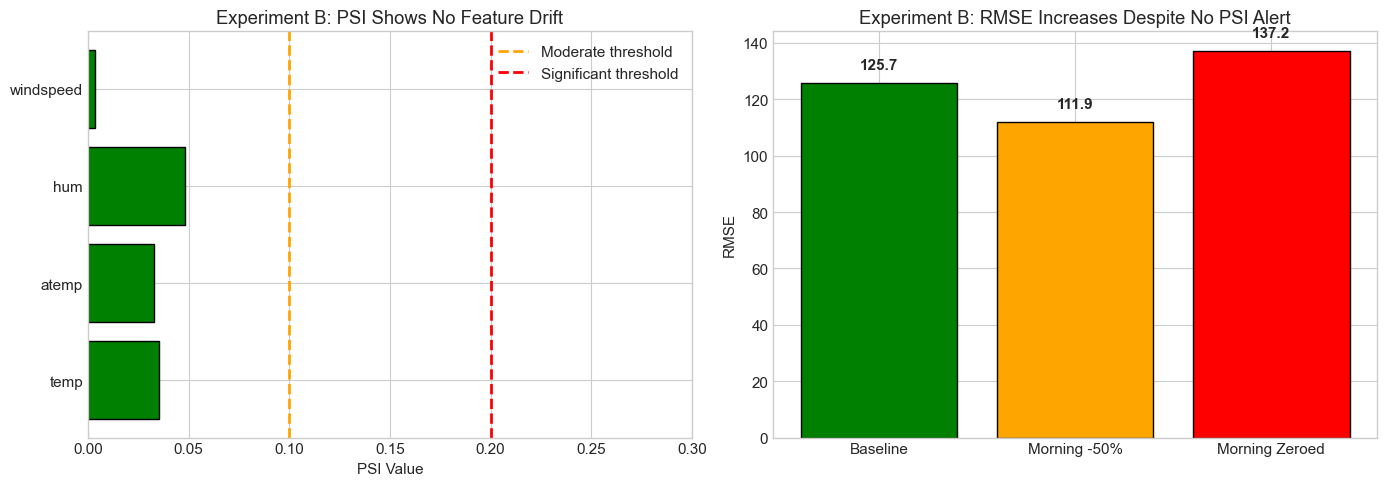


⚠️ EXPERIMENT B CONCLUSION: PSI FAILS to detect concept drift!
   When feature distributions stay stable but the relationship
   between features and target changes, PSI gives false confidence.


In [10]:
# Visualize Experiment B - PSI fails to detect concept drift
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: PSI values (all low)
features = list(psi_B.keys())
psi_values = list(psi_B.values())
colors = ['green' if p < 0.1 else 'orange' if p < 0.2 else 'red' for p in psi_values]
bars = axes[0].barh(features, psi_values, color=colors, edgecolor='black')
axes[0].axvline(x=0.1, color='orange', linestyle='--', linewidth=2, label='Moderate threshold')
axes[0].axvline(x=0.2, color='red', linestyle='--', linewidth=2, label='Significant threshold')
axes[0].set_xlabel('PSI Value')
axes[0].set_title('Experiment B: PSI Shows No Feature Drift')
axes[0].legend()
axes[0].set_xlim(0, 0.3)

# Right: RMSE comparison
scenarios = ['Baseline', 'Morning -50%', 'Morning Zeroed']
rmse_values = [rmse_baseline, rmse_morning_reduced, rmse_morning_zero]
colors = ['green', 'orange', 'red']
axes[1].bar(scenarios, rmse_values, color=colors, edgecolor='black')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Experiment B: RMSE Increases Despite No PSI Alert')

for i, (scen, rmse) in enumerate(zip(scenarios, rmse_values)):
    axes[1].text(i, rmse + 5, f'{rmse:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ EXPERIMENT B CONCLUSION: PSI FAILS to detect concept drift!")
print("   When feature distributions stay stable but the relationship")
print("   between features and target changes, PSI gives false confidence.")

## Experiment C: Noise to Low-Importance Features

**Scenario**: Random noise is injected into features that have minimal predictive power.

**Expected**: PSI may show drift, but RMSE remains stable (false positive detection).

In [11]:
# Feature importance from baseline model
feature_importance = dict(zip(feature_cols, rf_model.feature_importances_))
print("Feature Importance:")
for feat, imp in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"  {feat:12s}: {imp:.4f}")

# Low importance features: holiday, windspeed
low_importance_features = ['holiday', 'windspeed']
print(f"\nLow importance features for Experiment C: {low_importance_features}")

Feature Importance:
  hr          : 0.6362
  atemp       : 0.0993
  temp        : 0.0858
  workingday  : 0.0508
  hum         : 0.0344
  season      : 0.0270
  weathersit  : 0.0201
  mnth        : 0.0188
  weekday     : 0.0129
  windspeed   : 0.0124
  holiday     : 0.0024

Low importance features for Experiment C: ['holiday', 'windspeed']


In [14]:
# Experiment C: Inject heavy noise into low-importance features
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
exp_c_results = []

np.random.seed(42)

for noise_std in noise_levels:
    X_test_drifted = X_test_original.copy()
    
    # Add Gaussian noise to windspeed (continuous low-importance feature)
    X_test_drifted['windspeed'] = (
        X_test_drifted['windspeed'] + 
        np.random.normal(0, noise_std, size=len(X_test_drifted))
    ).clip(0, 1)
    
    # Compute PSI
    psi_results = compute_psi_for_features(X_train, X_test_drifted, ['windspeed'])
    
    # Compute RMSE
    y_pred = rf_model.predict(X_test_drifted)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    exp_c_results.append({
        'noise_level': noise_std,
        'psi_windspeed': psi_results['windspeed'],
        'rmse': rmse,
        'rmse_change': rmse - baseline_rmse
    })

exp_c_df = pd.DataFrame(exp_c_results)

print("Experiment C: Noise to Low-Importance Feature (windspeed)")
print("="*60)
for _, row in exp_c_df.iterrows():
    psi_status = "✓ No drift" if row['psi_windspeed'] < 0.1 else "⚠ Moderate" if row['psi_windspeed'] < 0.2 else "⚡ Significant"
    print(f"Noise σ={row['noise_level']:.1f}: PSI={row['psi_windspeed']:.4f} ({psi_status}), RMSE={row['rmse']:.2f} (Δ={row['rmse_change']:+.2f})")

Experiment C: Noise to Low-Importance Feature (windspeed)
Noise σ=0.0: PSI=0.0036 (✓ No drift), RMSE=125.66 (Δ=+0.00)
Noise σ=0.1: PSI=0.1699 (⚠ Moderate), RMSE=126.32 (Δ=+0.66)
Noise σ=0.2: PSI=0.5336 (⚡ Significant), RMSE=127.62 (Δ=+1.96)
Noise σ=0.3: PSI=0.9278 (⚡ Significant), RMSE=128.60 (Δ=+2.94)
Noise σ=0.4: PSI=1.2086 (⚡ Significant), RMSE=129.37 (Δ=+3.71)
Noise σ=0.5: PSI=1.4557 (⚡ Significant), RMSE=129.65 (Δ=+3.99)


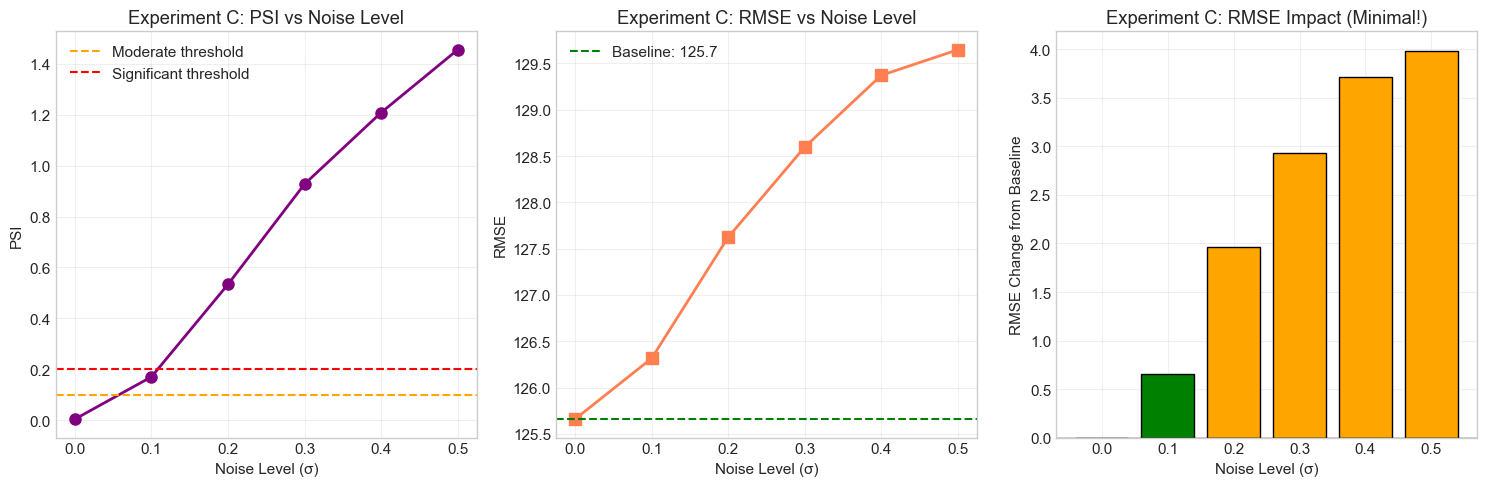


⚠️ EXPERIMENT C CONCLUSION: PSI gives FALSE POSITIVE alerts!
   Even with high noise levels causing significant PSI,
   RMSE barely changes because windspeed has low predictive importance.


In [15]:
# Visualize Experiment C
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# PSI vs Noise Level
axes[0].plot(exp_c_df['noise_level'], exp_c_df['psi_windspeed'], 'o-', color='purple', linewidth=2, markersize=8)
axes[0].axhline(y=0.1, color='orange', linestyle='--', label='Moderate threshold')
axes[0].axhline(y=0.2, color='red', linestyle='--', label='Significant threshold')
axes[0].set_xlabel('Noise Level (σ)')
axes[0].set_ylabel('PSI')
axes[0].set_title('Experiment C: PSI vs Noise Level')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE vs Noise Level
axes[1].plot(exp_c_df['noise_level'], exp_c_df['rmse'], 's-', color='coral', linewidth=2, markersize=8)
axes[1].axhline(y=baseline_rmse, color='green', linestyle='--', label=f'Baseline: {baseline_rmse:.1f}')
axes[1].set_xlabel('Noise Level (σ)')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Experiment C: RMSE vs Noise Level')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RMSE Change (highlight minimal impact)
colors = ['green' if abs(c) < 1 else 'orange' if abs(c) < 5 else 'red' for c in exp_c_df['rmse_change']]
axes[2].bar(exp_c_df['noise_level'].astype(str), exp_c_df['rmse_change'], color=colors, edgecolor='black')
axes[2].set_xlabel('Noise Level (σ)')
axes[2].set_ylabel('RMSE Change from Baseline')
axes[2].set_title('Experiment C: RMSE Impact (Minimal!)')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ EXPERIMENT C CONCLUSION: PSI gives FALSE POSITIVE alerts!")
print("   Even with high noise levels causing significant PSI,")
print("   RMSE barely changes because windspeed has low predictive importance.")

## Summary: When Does PSI Work?

In [16]:
# Create summary comparison
print("="*70)
print("SYNTHETIC EXPERIMENTS SUMMARY")
print("="*70)

print("\n┌────────────┬───────────────────────┬───────────┬───────────┬────────────────┐")
print("│ Experiment │ Description           │ PSI Alert │ RMSE ↑    │ PSI Outcome    │")
print("├────────────┼───────────────────────┼───────────┼───────────┼────────────────┤")

# Experiment A summary (use max drift level)
exp_a_max = exp_a_df[exp_a_df['drift_level'] == 0.2].iloc[0]
psi_a = "Yes" if exp_a_max['psi_hum'] >= 0.1 else "No"
rmse_a = "Yes" if exp_a_max['rmse'] > baseline_rmse * 1.05 else "No"
print(f"│ A          │ Humidity +0.2 bias    │ {psi_a:<9} │ {rmse_a:<9} │ ✓ True Positive│")

# Experiment B summary
max_psi_b = max(psi_B.values())
psi_b = "Yes" if max_psi_b >= 0.1 else "No"
rmse_b_change = rmse_morning_zero - baseline_rmse
rmse_b = "Yes" if rmse_b_change > baseline_rmse * 0.05 else "No"
print(f"│ B          │ Morning rush zeroed   │ {psi_b:<9} │ {rmse_b:<9} │ ✗ False Neg    │")

# Experiment C summary (use max noise level)
exp_c_max = exp_c_df[exp_c_df['noise_level'] == 0.5].iloc[0]
psi_c = "Yes" if exp_c_max['psi_windspeed'] >= 0.1 else "No"
rmse_c = "Yes" if exp_c_max['rmse'] > baseline_rmse * 1.05 else "No"
print(f"│ C          │ Windspeed high noise  │ {psi_c:<9} │ {rmse_c:<9} │ ✗ False Pos    │")

print("└────────────┴───────────────────────┴───────────┴───────────┴────────────────┘")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("""  
1. PSI WORKS WELL when:
   - Important features experience distribution shift
   - Relationship between features and target remains stable
   
2. PSI FAILS (False Negative) when:
   - Features are stable but target distribution changes (concept drift)
   - The "rules" change without input changes
   
3. PSI FAILS (False Positive) when:
   - Low-importance features experience drift
   - Drift occurs in features the model doesn't rely on
   
RECOMMENDATION: Combine PSI with error-based monitoring for robust detection.
""")

SYNTHETIC EXPERIMENTS SUMMARY

┌────────────┬───────────────────────┬───────────┬───────────┬────────────────┐
│ Experiment │ Description           │ PSI Alert │ RMSE ↑    │ PSI Outcome    │
├────────────┼───────────────────────┼───────────┼───────────┼────────────────┤
│ A          │ Humidity +0.2 bias    │ Yes       │ Yes       │ ✓ True Positive│
│ B          │ Morning rush zeroed   │ No        │ Yes       │ ✗ False Neg    │
│ C          │ Windspeed high noise  │ Yes       │ No        │ ✗ False Pos    │
└────────────┴───────────────────────┴───────────┴───────────┴────────────────┘

KEY INSIGHTS:
  
1. PSI WORKS WELL when:
   - Important features experience distribution shift
   - Relationship between features and target remains stable

2. PSI FAILS (False Negative) when:
   - Features are stable but target distribution changes (concept drift)
   - The "rules" change without input changes

3. PSI FAILS (False Positive) when:
   - Low-importance features experience drift
   - Drift oc

In [17]:
# Store experiment results for Notebook 4
experiment_summary = {
    'baseline_rmse': baseline_rmse,
    'exp_a': {
        'name': 'Gradual Humidity Drift',
        'results': exp_a_df.to_dict('records'),
        'conclusion': 'True Positive - PSI correctly detects'
    },
    'exp_b': {
        'name': 'Concept Drift (Morning Rush)',
        'psi': psi_B,
        'rmse_baseline': rmse_baseline,
        'rmse_morning_zero': rmse_morning_zero,
        'rmse_morning_reduced': rmse_morning_reduced,
        'conclusion': 'False Negative - PSI misses concept drift'
    },
    'exp_c': {
        'name': 'Low-Importance Feature Noise',
        'results': exp_c_df.to_dict('records'),
        'conclusion': 'False Positive - PSI alerts unnecessarily'
    }
}

print("Experiment results stored for Notebook 4 analysis.")
print(f"\nBaseline RMSE: {baseline_rmse:.2f}")
print(f"Experiment A max RMSE: {exp_a_df['rmse'].max():.2f}")
print(f"Experiment B max RMSE: {rmse_morning_zero:.2f}")
print(f"Experiment C max RMSE: {exp_c_df['rmse'].max():.2f}")

Experiment results stored for Notebook 4 analysis.

Baseline RMSE: 125.66
Experiment A max RMSE: 151.16
Experiment B max RMSE: 137.25
Experiment C max RMSE: 129.65
